Now that we have the datasets refreshed with 2017 data, let's repeat last year's analysis with a more specific intent to see who in Australia has been contributing to nips

## Admin and imports

In [37]:
from bs4 import BeautifulSoup
import json
import os, sys
import pandas as pd; import numpy as np
import re
import requests
import subprocess
from datetime import  datetime, date, timedelta
import seaborn as sns

## Import dataset

In [2]:
df_auth = pd.read_json('output/authors.json')
df_paper = pd.read_json('output/papers.json')
df_pa = pd.read_json('output/paper_authors.json')
df_auth.shape, df_paper.shape, df_pa.shape

((9787, 1), (7241, 6), (20843, 2))

## filter for country specific papers and authors

### Mark all papers likely from Australian authors

In [3]:
df_paper['paper_length'] = df_paper['paper_text'].str.split().apply(len)

In [4]:
# get the first 500 words of the paper text
df_paper['paper_text_500_words'] = df_paper['paper_text'].apply(lambda x: ' '.join(x.split()[:500]))

In [6]:
# from an initial inspection of papers last year, I had noticed that authors from a particular country
# features the name of the country somewhere - either after the university or in the abstract. So my guess
# is that we can mine the first 500 words of a paper to see whether that paper by an Ozzie author. 
# obviously, there's huge chances of there being false positives, but what's the downside? I'll read an 
# additional paper from the top conference in my field?
df_paper['country_paper'] = np.where(df_paper['paper_text_500_words'].str.upper().str.contains('AUSTRALIA'),1,0)

In [24]:
df_paper['country_paper'].value_counts()

0    7077
1     164
Name: country_paper, dtype: int64

Last year, i had gotten 154 papers with the same criterion. So safe to say that ~10 papers have been submitted in 2017. This will be a good litmus test.

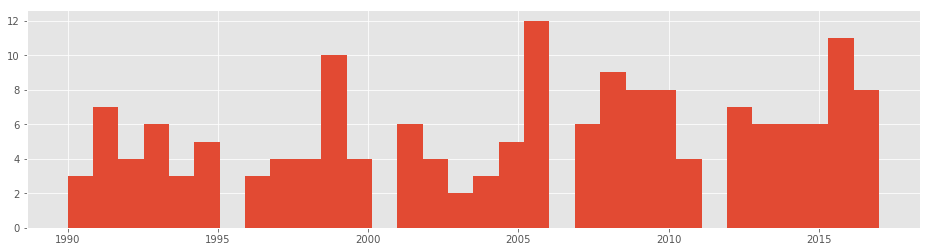

In [14]:
import matplotlib; import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot'); fig = plt.figure(figsize=(16,4));ax = fig.add_subplot(111)
df_paper.loc[df_paper.country_paper==1,'year'].hist(bins=32)

Interesting to see a fairly steady research contribution inspite of the hype machine surrounding AI over the past few years. I know that in Australia, more people have been joining AI industry as well as more roles/jobs have been opening up. Is this gap at the top AI talent not being filled by premium AI researchers in the country?

In [23]:
# get authors into the ozi dataset
df_ozi = pd.merge(left=df_paper[df_paper.country_paper == 1], right=df_pa, left_index=True, right_on='paper_id',suffixes=('_papers', '_key'))
df_ozi = pd.merge(left = df_ozi, right = df_auth, how='left',left_on='author_id', right_index=True,suffixes=('_country', '_author'))
df_ozi.drop(['event_type','abstract','country_paper','paper_id','author_id'], axis = 1, inplace = True)
df_ozi.shape

(496, 7)

In [22]:
df_ozi.shape

(496, 7)

## Some exploratory analysis

In [26]:
df_paper[df_paper.country_paper==1].event_type.value_counts()

Poster       31
Spotlight     5
Oral          1
Name: event_type, dtype: int64

I found in previous years' analysis that the conference **oral presentations** are single track, there are no oral presentations scheduled at the same time as one another. There are **spotlight** sessions which are several 5 minute presentations back to back in roughly the same length of slot that one oral presentation would get. The **poster** sessions are one big, loud, overcrowded science fair type thing held in the evenings of the main conference.

[]

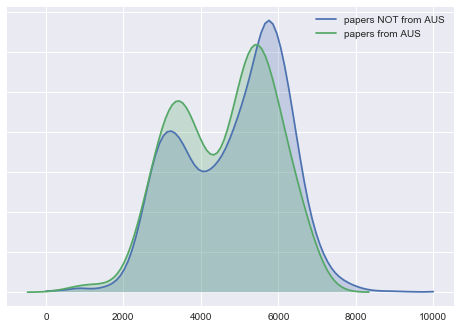

In [38]:
# how big are the papers?
fig, ax = plt.subplots()
sns.kdeplot(df_paper.loc[df_paper.country_paper != 1,'paper_length'], shade=True, ax = ax, clip=(0,10000))
sns.kdeplot(df_paper.loc[df_paper.country_paper == 1,'paper_length'], shade=True, ax = ax)
ax.legend(labels=['papers NOT from AUS','papers from AUS'], loc = 'best')
ax.yaxis.set_ticklabels([])

A lot of papers are either 3K or 5.5K words...The density distribution in Australia and elsewhere is surprising. Is this one of nips requirements?

## Lets impute university affiliations

In [41]:
# create a list of unis that you want to one-hot encode. When you refactor this, it can be a user input
list_of_unis = ['NICTA','Data61','National ICT Australia','CSIRO','Australian National University','University of Sydney',
                'Deakin University','University of New South Wales','University of Technology Sydney',
                'University of Queensland','Curtin University of Technology','University of Adelaide',
                'Sydney University','UNSW','University of Melbourne','Univ. of Sydney','University of Newcastle']

In [ ]:
df_ozi['affiliation'] = ''
for uni in list_of_unis:
    df_ozzie['affiliation'] = np.where(df_ozzie.paper_text_500_words.str.contains(uni),uni,df_ozzie['affiliation'])

In [35]:
# a few names of authors since 2010
print ('{} authors for analysis'.format(df_ozi.loc[df_ozi.year > 2010,'name'].value_counts().shape[0]))
df_ozi.loc[df_ozi.year > 2010,'name'].value_counts().head(20)       

125 authors for analysis


Justin Domke            5
Mark D. Reid            4
Xinhua Zhang            4
Robert C. Williamson    4
Richard Nock            4
Xianghang Liu           3
Aaron Defazio           3
Ian Reid                3
Tib?rio S. Caetano      3
Chunhua Shen            3
Tong Zhang              2
Aditya Menon            2
Weidong Cai             2
Trung Le                2
Heng Huang              2
Tu Nguyen               2
Peng Lin                2
Mathieu Salzmann        2
Dale Schuurmans         2
James Petterson         2
Name: name, dtype: int64

In [40]:
# SO WHO PUBLISHED THIS YEAR?
df_ozi[df_ozi.year == 2017].groupby(by=['name','year']).count()['title'].sort_values(ascending = False)

name                  year
Ian Reid              2017    2
Tong Zhang            2017    2
Zac Cranko            2017    1
Heng Huang            2017    1
Lyle Palmer           2017    1
Lizhen Qu             2017    1
Lijie Fan             2017    1
Junzhou Huang         2017    1
Hung Vu               2017    1
Hongdong Li           2017    1
Hong Chen             2017    1
Gustavo Carneiro      2017    1
Mehrtash Harandi      2017    1
Fuchun Sun            2017    1
Dinh Phung            2017    1
Dinggang Shen         2017    1
David Rubin           2017    1
Carl Jidling          2017    1
Alessandra Sutti      2017    1
Adrian Wills          2017    1
Mathieu Salzmann      2017    1
Murray Height         2017    1
Xiaoqian Wang         2017    1
Thomas B. Sch?n       2017    1
Wenbing Huang         2017    1
Weidong Cai           2017    1
Tu Nguyen             2017    1
Trung Pham            2017    1
Trung Le              2017    1
Toan Tran             2017    1
Thomas Dorin 